# Data Release

In [ ]:
! git pull 

In [1]:
%%capture
import pandas as pd 
from bbg import bdh, bdh_bulk
import numpy as np 
import re
from collections import defaultdict
from datetime import timedelta
import itertools
import matplotlib.pyplot as plt

In [2]:
regiondict= defaultdict()
regiondict['g10_exeu'] = ['CA','US','AU','NZ']
regiondict['g10_eu'] = ['GE', 'EC','IT','UK','SW','FR','NO']
regiondict['asia_main'] = ['CH','JN','HK','SK']
regiondict['asia_em']  = ['ID','MA','TA','PH','IN','TH','VN']
regiondict['latam'] = ['BZ','MX','CL','CO','AR','PE','DR','CR']
regiondict['ceemea'] = ['RO','HU','PD','CZ', 'SA','TU'] # 'EG','GH',IS

In [3]:
def _color_red_or_green(val):
    color = 'red' if val < 0 else 'green'
    return 'color: %s' % color

def show_country(ccy,relevance):
    result = world[world['relevance']>=relevance ]
    result  = result[result['country'].isin(regiondict[ccy])][['event','country','survey','actual','prior','diff_prior','diff_exp','period','ticker','relevance']]
    result.index = pd.Series(result.index).apply ( lambda x : x[:-5])
    result.loc[result['event'].str.contains('obless' or 'nemployment'),'diff_exp']*= -1
    result.loc[result['event'].str.contains('obless' or 'nemployment'),'diff_prior']*= -1 
    result.loc[result['event'].str.contains( 'nemployment'),'diff_exp']*= -1
    result.loc[result['event'].str.contains( 'nemployment'),'diff_prior']*= -1 
    result = result.dropna(subset= ['actual'])
    return result.reset_index().sort_values('relevance',ascending = False)#.style.background_gradient(subset = ['diff_exp'],cmap='ocean_r')

In [10]:
world = pd.read_excel('eco_world.xlsx' )
world = world[['Date Time', 'Unnamed: 1', 'Event',
       'Unnamed: 5', 'Survey', 'Actual', 'Prior', 'Revised', 'Relevance',
       'Ticker']]
world.columns = ['asofdate','country','event','period','survey','actual','prior','revised','relevance','ticker']
#world = world[world['relevance'] >= 80]
world.set_index('asofdate', inplace= True)
world = world.apply(lambda x : x.replace('--',np.nan)).apply(lambda x : x.replace('-',np.nan))
world = world.sort_values(by = 'relevance', ascending = False)

test =world[['prior','actual','survey']]
numeric = world[test.applymap(np.isreal).all(1)]
nonnumeric =  world[~test.applymap(np.isreal).all(1)]
nonnumeric[['prior','actual','survey']] = nonnumeric[['prior','actual','survey']].apply(lambda x: x.str.replace(r"[a-zA-Z\$¥£]",'', regex = True))
world  = numeric.append(nonnumeric)
world[['prior','actual','survey']] = world[['prior','actual','survey']].astype(float)

world['diff_exp'] = (world['actual'] - world['survey'])/abs(world['survey'])
world['diff_prior'] = (world['actual'] - world['prior'])/abs(world['prior'])

In [11]:
g10exeu = show_country('g10_exeu',80)
eu = show_country('g10_eu',85)
ceemea = show_country('ceemea',80)
latam = show_country('latam',75)
asia_main = show_country('asia_main',80)
asia_em = show_country('asia_em',70)


In [12]:
"""plots the top 3 most important datapoints per each region"""

def make_region_overview(df, region_name): 
    df = df[(~df.event.str.contains('CPI MoM')) ]
    df = df[(~df.event.str.contains('MBA')) ]
    df = df[(~df.event.str.contains('CPI Level')) ]
    df = df[(~df.event.str.contains('IPCA')) ]
    df = df[(~df.event.str.contains('IGPM MoM')) ]
    df = df[(~df.event.str.contains('Bi-Weekly CPI')) ]
    df = df[(~df.event.str.contains('Core Machine')) ]
    df = df[(~df.event.str.contains('GDP QoQ')) ]
    df = df.drop_duplicates(subset='event')
    print(region_name)
    df = df.head(3)
    title = list(df['country'] +' ' + df['event'])
    tkr = list(df['ticker'])
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
    for i in range(0,len(tkr)):
        bdh(tkr[i],'PX_LAST','19900101','20300101').loc['2015-01-01':].plot(ax = axes[i],title = title[i])


## Overview by region

G10_ex_EU


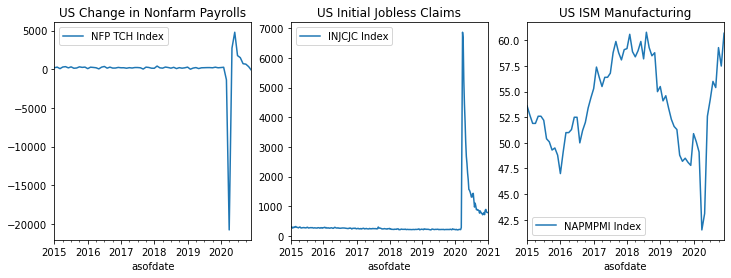

In [13]:
make_region_overview(g10exeu, 'G10_ex_EU')

EU


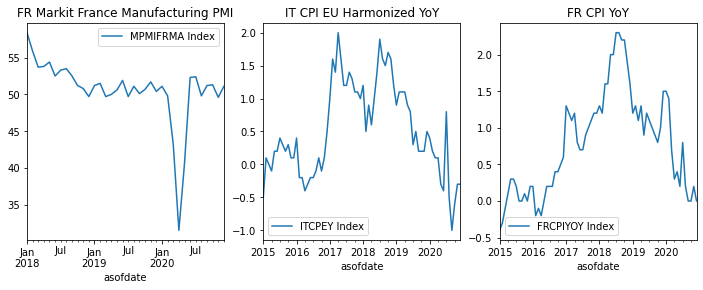

In [14]:
make_region_overview(eu, 'EU')

CEEMEA


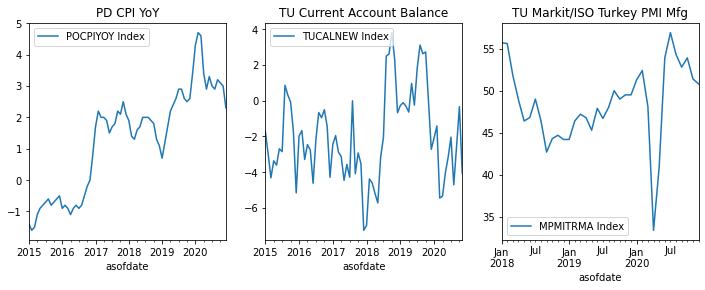

In [15]:
make_region_overview( ceemea, 'CEEMEA')

LatAM


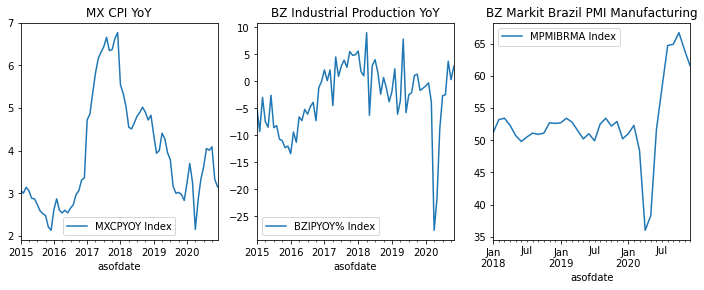

In [16]:
make_region_overview( latam, 'LatAM')

Asia_Main


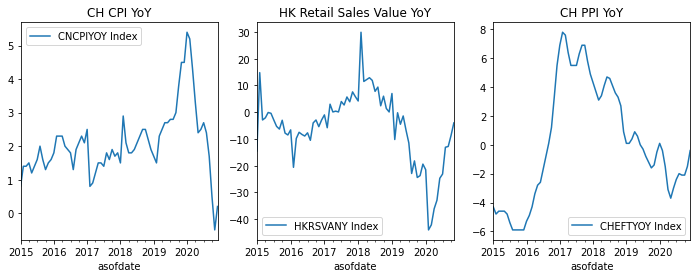

In [17]:
make_region_overview(asia_main , 'Asia_Main')

Asia_EM


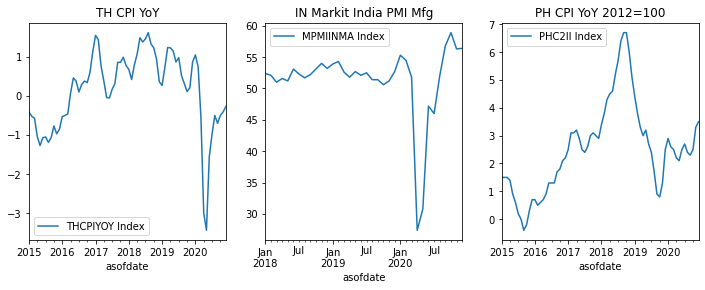

In [18]:
make_region_overview( asia_em, 'Asia_EM')

### Econ release Table

In [19]:
print('G10_ex EU')
g10exeu.style.applymap(_color_red_or_green, subset=['diff_exp','diff_prior'])

G10_ex EU


,asofdate,event,country,survey,actual,prior,diff_prior,diff_exp,period,ticker,relevance
13,01/08/2021,Change in Nonfarm Payrolls,US,50.000000,-140.000000,245.000000,-1.571429,-3.800000,Dec,NFP TCH Index,99.212600
14,01/07/2021,Initial Jobless Claims,US,800.000000,787.000000,787.000000,-0.000000,0.016250,2021-01-02 00:00:00,INJCJC Index,98.425200
0,01/05/2021,ISM Manufacturing,US,56.800000,60.700000,57.500000,0.055652,0.068662,Dec,NAPMPMI Index,95.275600
1,01/06/2021,Durable Goods Orders,US,0.009000,0.010000,0.009000,0.111111,0.111111,Nov F,DGNOCHNG Index,92.913400
2,01/06/2021,Building Approvals MoM,AU,0.020000,0.026000,0.038000,-0.315789,0.300000,Nov,AUBAC Index,92.753600
3,01/06/2021,MBA Mortgage Applications,US,nan,0.017000,-0.058000,1.293103,nan,2021-01-01 00:00:00,MBAVCHNG Index,92.307700
4,01/10/2021,Retail Sales MoM,AU,0.070000,0.071000,0.070000,0.014286,0.014286,Nov F,AURSTSA Index,91.304300
5,01/08/2021,Unemployment Rate,CA,0.087000,0.086000,0.085000,-0.011765,0.011494,Dec,CANLXEMR Index,90.476200
6,01/04/2021,Markit Canada Manufacturing PMI,CA,nan,57.900000,55.800000,0.037634,nan,Dec,MPMICAMA Index,90.000000
7,01/04/2021,Markit US Manufacturing PMI,US,56.300000,57.100000,56.500000,0.010619,0.014210,Dec F,MPMIUSMA Index,90.000000


In [20]:
print('G10_EU')
eu.style.applymap(_color_red_or_green, subset=['diff_exp','diff_prior'])

G10_EU


,asofdate,event,country,survey,actual,prior,diff_prior,diff_exp,period,ticker,relevance
0,01/04/2021,Markit France Manufacturing PMI,FR,51.100000,51.100000,51.100000,0.000000,0.000000,Dec F,MPMIFRMA Index,97.058800
1,01/07/2021,CPI EU Harmonized YoY,IT,-0.003000,-0.003000,-0.003000,0.000000,0.000000,Dec P,ITCPEY Index,94.594600
2,01/06/2021,CPI YoY,FR,0.002000,0.000000,0.002000,-1.000000,-1.000000,Dec P,FRCPIYOY Index,94.117600
3,01/04/2021,DNB/NIMA PMI Manufacturing,NO,52.500000,51.900000,51.900000,0.000000,-0.011429,Dec,NOPMISA Index,93.103400
4,01/04/2021,Swedbank/Silf PMI Manufacturing,SW,nan,64.900000,59.100000,0.098139,nan,Dec,PMISSURV Index,92.682900
5,01/08/2021,Industrial Production SA MoM,GE,0.008000,0.009000,0.032000,-0.718750,0.125000,Nov,GRIPIMOM Index,92.592600
6,01/08/2021,Industrial Production MoM,FR,-0.010000,-0.009000,0.016000,-1.562500,0.100000,Nov,FPIPMOM Index,91.176500
7,01/07/2021,Factory Orders MoM,GE,-0.005000,0.023000,0.029000,-0.206897,5.600000,Nov,GRIORTMM Index,90.740700
10,01/04/2021,Markit Eurozone Manufacturing PMI,EC,55.500000,55.200000,55.500000,-0.005405,-0.005405,Dec F,MPMIEZMA Index,90.000000
11,01/04/2021,Markit UK PMI Manufacturing SA,UK,57.300000,57.500000,57.300000,0.003490,0.003490,Dec F,MPMIGBMA Index,90.000000


In [21]:
print('CEEMEA')
ceemea.style.applymap(_color_red_or_green, subset=['diff_exp','diff_prior'])

CEEMEA


,asofdate,event,country,survey,actual,prior,diff_prior,diff_exp,period,ticker,relevance
0,01/07/2021,CPI YoY,PD,0.026000,0.023000,0.030000,-0.233333,-0.115385,Dec P,POCPIYOY Index,93.750000
1,01/04/2021,CPI YoY,TU,0.142000,0.146000,0.140300,0.040627,0.028169,Dec,TUCPIY Index,93.548400
8,01/11/2021,Current Account Balance,TU,-3.560000,-4.060000,-0.270000,-14.037037,-0.140449,Nov,TUCALNEW Index,90.322600
2,01/04/2021,Markit/ISO Turkey PMI Mfg,TU,nan,50.800000,51.400000,-0.011673,nan,Dec,MPMITRMA Index,90.000000
3,01/04/2021,Markit Poland PMI Mfg,PD,51.300000,51.700000,50.800000,0.017717,0.007797,Dec,MPMIPLMA Index,90.000000
4,01/04/2021,Markit Czech Republic PMI Mfg,CZ,54.300000,57.000000,53.900000,0.057514,0.049724,Dec,MPMICZMA Index,90.000000
5,01/08/2021,Industrial Production WDA YoY,HU,nan,0.016000,0.027000,-0.407407,nan,Nov,HUIPIYOY Index,85.714300
6,01/07/2021,Retail Sales YoY,RO,nan,0.051000,0.057000,-0.105263,nan,Nov,RORSUYOY Index,84.210500
7,01/04/2021,CPI MoM,TU,0.009000,0.012500,0.023000,-0.456522,0.388889,Dec,TUCPIM Index,83.871000


In [22]:
print('LATAM')
latam.style.applymap(_color_red_or_green, subset=['diff_exp','diff_prior'])

LATAM


,asofdate,event,country,survey,actual,prior,diff_prior,diff_exp,period,ticker,relevance
0,01/07/2021,CPI YoY,MX,0.031600,0.031500,0.033300,-0.054054,-0.003165,Dec,MXCPYOY Index,95.122000
1,01/08/2021,Industrial Production YoY,BZ,0.033000,0.028000,0.003000,8.333333,-0.151515,Nov,BZIPYOY% Index,92.982500
2,01/05/2021,CPI YoY,CO,0.014500,0.016100,0.014900,0.080537,0.110345,Dec,COCPIYOY Index,91.304300
3,01/07/2021,CPI MoM,MX,0.003900,0.003800,0.000800,3.750000,-0.025641,Dec,MXCPCHNG Index,90.243900
4,01/04/2021,Markit Brazil PMI Manufacturing,BZ,nan,61.500000,64.000000,-0.039062,nan,Dec,MPMIBRMA Index,90.000000
5,01/04/2021,Markit Mexico PMI Mfg,MX,nan,42.400000,43.700000,-0.029748,nan,Dec,MPMIMXMA Index,90.000000
11,01/04/2021,Government Tax Revenue,AR,nan,679.600000,649.000000,0.047149,nan,Dec,ARTXTOTL Index,90.000000
6,01/07/2021,Bi-Weekly CPI,MX,0.002100,0.001900,0.003400,-0.441176,-0.095238,2021-12-31 00:00:00,MXBWMOM Index,87.804900
7,01/05/2021,CPI MoM,CO,0.001900,0.003800,-0.001500,3.533333,1.000000,Dec,COCPIMOM Index,86.956500
8,01/11/2021,Industrial Production NSA YoY,MX,-0.042000,-0.037000,-0.033000,-0.121212,0.119048,Nov,MXIPTYOY Index,85.365900


In [23]:
print('Asia')
asia_main.style.applymap(_color_red_or_green, subset=['diff_exp','diff_prior'])

Asia


,asofdate,event,country,survey,actual,prior,diff_prior,diff_exp,period,ticker,relevance
0,01/10/2021,CPI YoY,CH,0.000000,0.002000,-0.005000,1.400000,inf,Dec,CNCPIYOY Index,95.744700
1,01/04/2021,Retail Sales Value YoY,HK,-0.074000,-0.040000,-0.088000,0.545455,0.459459,Nov,HKRSVANY Index,95.454500
2,01/10/2021,PPI YoY,CH,-0.007000,-0.004000,-0.015000,0.733333,0.428571,Dec,CHEFTYOY Index,89.361700


In [24]:
# print('EM Asia')
asia_em.style.applymap(_color_red_or_green, subset=['diff_exp','diff_prior'])

,asofdate,event,country,survey,actual,prior,diff_prior,diff_exp,period,ticker,relevance
0,01/04/2021,CPI YoY,TH,-0.003900,-0.002700,-0.004100,0.341463,0.307692,Dec,THCPIYOY Index,92.307700
1,01/04/2021,Markit India PMI Mfg,IN,nan,56.400000,56.300000,0.001776,nan,Dec,MPMIINMA Index,90.000000
2,01/07/2021,CPI YoY,TA,0.001000,0.000600,0.000900,-0.333333,-0.400000,Dec,TWCPIYOY Index,89.473700
3,01/04/2021,CPI YoY 2012=100,PH,0.032000,0.035000,0.033000,0.060606,0.093750,Dec,PHC2II Index,86.363600
8,01/08/2021,Foreign Reserves,TH,nan,257.800000,255.600000,0.008607,nan,2021-01-01 00:00:00,THFRUS$ Index,80.769200
9,01/07/2021,Foreign Reserves,ID,nan,135.900000,133.600000,0.017216,nan,Dec,IDGFA Index,76.470600
4,01/08/2021,Exports YoY,TA,0.100000,0.120000,0.120000,0.000000,0.200000,Dec,TWTREXPY Index,73.684200
5,01/07/2021,Exports YoY,PH,nan,0.030000,-0.022000,2.363636,nan,Nov,PHEXYOY Index,72.727300
6,01/06/2021,Markit India PMI Composite,IN,nan,54.900000,56.300000,-0.024867,nan,Dec,MPMIINCA Index,70.000000
7,01/06/2021,Markit India PMI Services,IN,nan,52.300000,53.700000,-0.026071,nan,Dec,MPMIINSA Index,70.000000


# Financial market monitor

In [44]:
# reer tickers
ccylist = ['BRL', 'NOK','EUR','GBP','AUD','NZD','IDR','MYR','SEK','TRY','JPY','KRW','MXN','USD','ZAR','CAD','CNH','THB','INR','HUF','PLN','CZK']
datadict = defaultdict()
alldata = defaultdict()

In [52]:
emccy = ['BRL','IDR','MYR','TRY','MXN','ZAR','CNH','THB','INR','HUF','PLN','CZK']
dmccy = ['NOK','EUR','GBP','NZD','AUD','JPY','KRW','USD','CAD','CNH','TRY','ZAR','HUF','IDR']
dmcombo = list(''.join(x) for x in itertools.permutations(dmccy,2))
emcombo = list(''.join(x) for x in itertools.permutations(emccy,2))

In [45]:
del_list = ['NOKPEN',
 'NZDPEN',
 'IDRRON',
 'IDRPE`N',
 'MYRPEN',
 'TRYPEN',
 'TRYVND',
 'KRWPEN',
 'MXNCNH',
 'RONIDR',
 'RONPEN',
 'RONCNH',
 'RONTHB',
 'RONPHP',
 'RONVND',
 'PENIDR',
 'PENMYR',
 'PENTRY',
 'PENRON',
 'PENCNH',
 'PENTHB',
 'PENPHP',
 'PENVND',
 'PENHUF',
 'PENPLN',
 'PENCZK',
 'CNHVND',
 'THBPEN',
 'PHPRON',
 'PHPPEN',
 'VNDIDR',
 'VNDTRY',
 'VNDRON',
 'VNDPEN',
 'VNDCNH',
 'VNDPLN',
 'HUFPEN',
 'HUFCNH',
 'PLNPEN',
 'CZKPEN',
 'CZKCNH']

In [56]:
# crosses tickers
crosseslist = [x for x in dmcombo if x not in set(dmcombo) & set(emcombo)]
crossestkr = [x + ' Curncy' for x in crosseslist]
# equities
equities ={ 'BRL' : 'IBOV Index', 'NOK':'OSEBX Index','EUR':'SXXP Index','GBP':'UKX Index','AUD':'AS51 Index',
           'NZD':'NZSE50FG Index','IDR':'JCI Index','MYR':'NZSE50FG Index','SEK':'OMX Index','TRY':'XU100 Index',
           'JPY':'NKY Index','KRW':'KOSPI Index','MXN':'MEXBOL Index','RON':'BET Index','USD':'SPX Index',
           'CHF':'SMI Index','ZAR':'TOP40 Index','CAD':'SPTSX Index','CNH':'SHCOMP Index','THB':'SET Index','PHP':'PCOMP Index',
           'VND':'VNINDEX Index','INR':'NIFTY Index','HUF':'BUX Index','PLN':'WIG20 Index','CZK':'PX Index'}
# swap2ytkr = [x + '.Swap.2y' for x in ccylist]
# swap5ytkr =  [x + '.Swap.5y' for x in ccylist]
# cdstkr = [x + '.CDS' for x in ccylist]
commotkr = {'oil':'CLA Comdty', 'natural_gas':'NGA Comdty','copper':'LOCADY LME Comdty','gold':'XAU Curncy',
            'iron_ore':'IOEA Comdty','soybeans':'S A Comdty'}

# alldata['swap2y'] = get_kls_series(swap2ytkr)
# alldata['swap5y'] = get_kls_series(swap5ytkr)
# alldata['cds'] = get_kls_series(cdstkr)
alldata['equities'] =  bdh_bulk(equities,'20190101','20500101')
crossesdic = dict(zip(crosseslist,crossestkr))
for x in del_list :
    try: 
        del crossesdic[x]
    except:
        None

alldata['crosses'] =  bdh_bulk(crossesdic,'20190101','20500101')
#alldata['reer']= bdh_bulk(reertkr,'20180101','20500101')
# alldata ['2s5s'] = alldata['swap5y'] - alldata['swap2y']
#alldata['reer'] = alldata['reer'][ccylist+['USD vs Asian Currencies', 'USD vs Latin American Currencies']]
alldata['commo'] =  bdh_bulk(commotkr,'20190101','20500101')




In [29]:
for i in list( alldata.keys()): 
    alldata[i + '_1dchg'] = (alldata[i] - alldata[i].shift(1)) / abs(alldata[i].shift(5))
    alldata[i + '_1wchg'] = (alldata[i] - alldata[i].shift(5)) / abs(alldata[i].shift(5))
    alldata[i + '_3mchg'] = (alldata[i] - alldata[i].shift(26*3)) / abs(alldata[i].shift(26*3))
    alldata[i + '_1ddelta'] = (alldata[i] - alldata[i].shift(1)) 
    alldata[i + '_1wdelta'] = (alldata[i] - alldata[i].shift(5)) 
    alldata[i + '_3mdelta'] = (alldata[i] - alldata[i].shift(26*3)) 

In [30]:
def show_charts(key):
    df = alldata[key]
    df = df.tail(5).fillna(method = 'ffill')
    df = df.tail(1)
    df = df.dropna(axis = 1)
    df.index =df.index.astype(str)
    df = df.transpose()
    date = df.columns[0]
    df = df.sort_values(date)
    result = df.head(5).append( df.tail(5))
#     ax = result.plot(kind = 'bar', title = key)
#     ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    return result

def show_charts2(key):
    df = alldata[key]
    df = df.tail(10).fillna(method = 'ffill')
    df = df.tail(1)
    df = df.dropna(axis = 1)
    df.index =df.index.astype(str)
    df = df.transpose()
    date = df.columns[0]
    df = df.sort_values(date)
    result = df.tail(10)
#     ax = result.plot(kind = 'bar', title = key)
#     ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    return result
    

In [31]:
# reer_1dchg = show_charts('reer_1dchg')
# reer_1wchg = show_charts('reer_1wchg')
# reer_3mchg = show_charts('reer_3mchg')

# fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
# reer_1dchg.plot(ax = axes[0],kind = 'bar', title ='reer_1dchg' )
# reer_1wchg.plot(ax = axes[1],kind = 'bar', title ='reer_1wchg' )
# reer_3mchg.plot(ax = axes[2],kind = 'bar',title = 'reer_3mchg')

<AxesSubplot:title={'center':'crosses_3mchg'}>

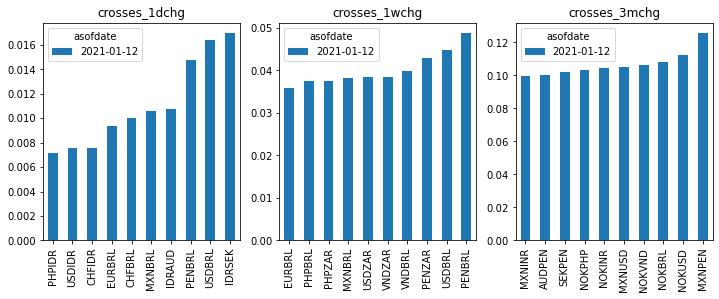

In [32]:
crosses_1dchg = show_charts2('crosses_1dchg')
crosses_1wchg = show_charts2('crosses_1wchg')
crosses_3mchg = show_charts2('crosses_3mchg')

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
crosses_1dchg.plot(ax = axes[0],kind = 'bar', title ='crosses_1dchg' )
crosses_1wchg.plot(ax = axes[1],kind = 'bar', title ='crosses_1wchg' )
crosses_3mchg.plot(ax = axes[2],kind = 'bar',title = 'crosses_3mchg')

<AxesSubplot:title={'center':'equities_3mchg'}>

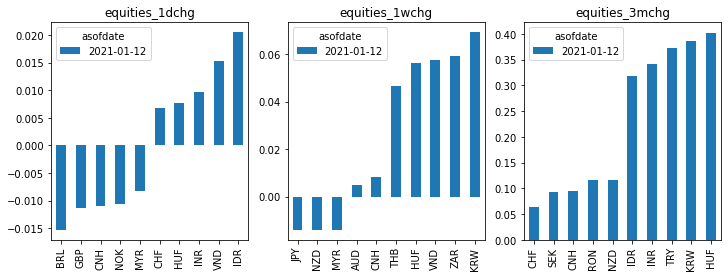

In [33]:
equities_1dchg = show_charts('equities_1dchg')
equities_1wchg = show_charts('equities_1wchg')
equities_3mchg = show_charts('equities_3mchg')

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
equities_1dchg.plot(ax = axes[0],kind = 'bar', title ='equities_1dchg' )
equities_1wchg.plot(ax = axes[1],kind = 'bar', title ='equities_1wchg' )

equities_3mchg.plot(ax = axes[2],kind = 'bar',title = 'equities_3mchg')

<AxesSubplot:title={'center':'commo_3mchg'}>

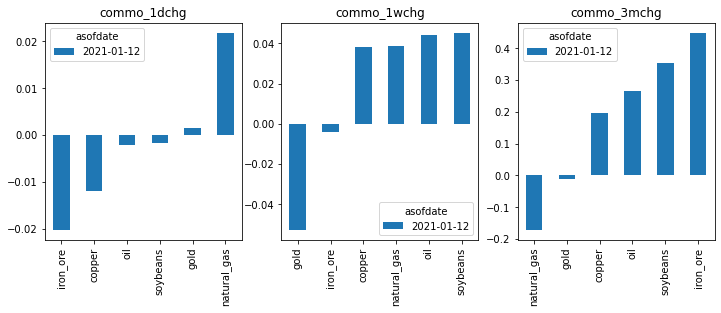

In [34]:
commo_1dchg = show_charts2('commo_1dchg')
commo_1wchg = show_charts2('commo_1wchg')
commo_3mchg = show_charts2('commo_3mchg')

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
commo_1dchg.plot(ax = axes[0],kind = 'bar', title ='commo_1dchg' )
commo_1wchg.plot(ax = axes[1],kind = 'bar', title ='commo_1wchg' )
commo_3mchg.plot(ax = axes[2],kind = 'bar',title = 'commo_3mchg')

# Positioning

### Risk reversal

In [35]:
emccy = ['THB','MXN','RUB','TRY','INR','CNH','ZAR','BRL','CLP','IDR','PHP','PEN','COP','HUF','PLN']
dmccy = ['ILS','JPY','GBP','CAD','CHF','NZD','SEK','AUD','NOK','EUR','KRW']
emccytkr = ['USD' + ccy + '25R3M Curncy' for ccy in emccy]
dmccytkr = ['USD' + ccy + '25R3M Curncy' for ccy in dmccy]
rrem = defaultdict()
rrdm = defaultdict()

In [36]:
dmtkr= dict(zip(dmccy,dmccytkr ))
dmtkr['AUD'] = 'AUDUSD25R3M Curncy'
dmtkr['EUR'] = 'EURUSD25R3M Curncy'
dmtkr['GBP'] = 'GBPUSD25R3M Curncy'
dmtkr['NZD'] = 'NZDUSD25R3M Curncy'

In [37]:
rrdict = defaultdict()
rrdict['em']  = bdh_bulk(dict(zip(emccy,emccytkr )), '19900101','20200101').fillna(method = 'ffill')
rrdict['dm'] = bdh_bulk( dmtkr, '19900101','20200101').fillna(method = 'ffill')

In [38]:
rrdict['em'] = rrdict['em'] * (-1)
rrdict['dm'][['ILS','JPY','CAD','CHF','SEK','NOK','KRW']] = rrdict['dm'][['ILS','JPY','CAD','CHF','SEK','NOK','KRW']] * (-1)

for i in list(rrdict.keys()): 
    rrdict[i+ '_3mz'] =  (rrdict[i] - rrdict[i].rolling(60).mean())/rrdict[i].rolling(60).std()
    rrdict[i+ '_1yz'] =  (rrdict[i] - rrdict[i].rolling(240).mean())/rrdict[i].rolling(240).std()

In [39]:
emrrresult = rrdict['em_3mz'].tail(1).append(rrdict['em_1yz'].tail(1))
emrrresult = emrrresult.transpose()
emrrresult.columns = ['3M','12M']
#emrrresult.index = pd.Series(emrrresult.index).apply(lambda x : x + 'USD')
emrrresult = emrrresult.sort_values(by = '12M')

In [40]:
emrrresult

,3M,12M
CLP,-0.276483,-0.913260
COP,-1.168274,-0.346822
CNH,1.692402,0.034006
PEN,1.406960,0.755215
TRY,0.175167,1.012189
MXN,1.407171,1.166339
ZAR,-0.347041,1.234219
PHP,0.536779,1.326939
HUF,0.829565,1.395886
INR,0.943982,1.433506


In [41]:
dmrrresult = rrdict['dm_3mz'].tail(1).append(rrdict['dm_1yz'].tail(1))
dmrrresult = dmrrresult.transpose()
dmrrresult.columns = ['3M','12M']
#dmrrresult
#dmrrresult.index = pd.Series(dmrrresult.index).apply(lambda x : x + 'USD')
dmrrresult = dmrrresult.sort_values(by = '3M')

In [42]:
dmrrresult

,3M,12M
ILS,-1.257806,-1.315683
JPY,-0.234285,-0.423387
CHF,0.404390,0.212250
AUD,0.650886,1.203860
CAD,0.678556,1.400515
NZD,0.769465,1.343100
KRW,1.358507,0.989942
GBP,1.524598,1.222573
NOK,1.646934,1.467416
SEK,2.165371,1.713552


In [43]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [ ]:
!git add macro_screener.ipynb eco_world.xlsx
!git config --global user.email "my2437@columbia.edu"
!git config --global user.name "windflower715"
!git commit -m"macro_screener and eco world file"
!git push
